# Neural Network Classification of 

In [2]:
import pandas as pd
import numpy as np
from random import randint

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

import seaborn as sns 
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from keras.models import Sequential
from keras.metrics import Precision, Recall, F1Score
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [3]:
data = pd.read_csv("data/magic04.csv", index_col=0)
data['class'] = data['class'].replace('g',1.0)
data['class'] = data['class'].replace('h',0.0)
data.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1.0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1.0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1.0
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1.0
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1.0


## Define Features and Class

Define the features, classes, and standardize the feature columns

In [4]:
featureNames = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
classCols = ['class']
classNames = ['h', 'g']
num_features = len(featureNames)
num_outputs = len(classCols)
# for featureName in featureNames:
#     data[featureName] = (data[featureName] - data[featureName].mean()) / data[featureName].std()

# data.head()

## Feature Selection

In [5]:
for feature in featureNames:
    (r,p) = pearsonr(data[feature], data[classCols])
    print(feature,' r =', r[0], 'p =', p)

fLength  r = -0.30757224620373963 p = 0.0
fWidth  r = -0.2655964388163358 p = 1.7261275200255766e-304
fSize  r = -0.11779459173758182 p = 9.690427369681911e-60
fConc  r = 0.024614509221041733 p = 0.0006864052764991323
fConc1  r = 0.004797273270669878 p = 0.5082489228794462
fAsym  r = 0.17358725739062048 p = 1.4798663724927532e-128
fM3Long  r = 0.19340905100370523 p = 1.0756080256114858e-159
fM3Trans  r = -0.003837198068757369 p = 0.596689796312866
fAlpha  r = -0.4609793933309626 p = 0.0
fDist  r = -0.06520263487388497 p = 2.231012772197107e-19


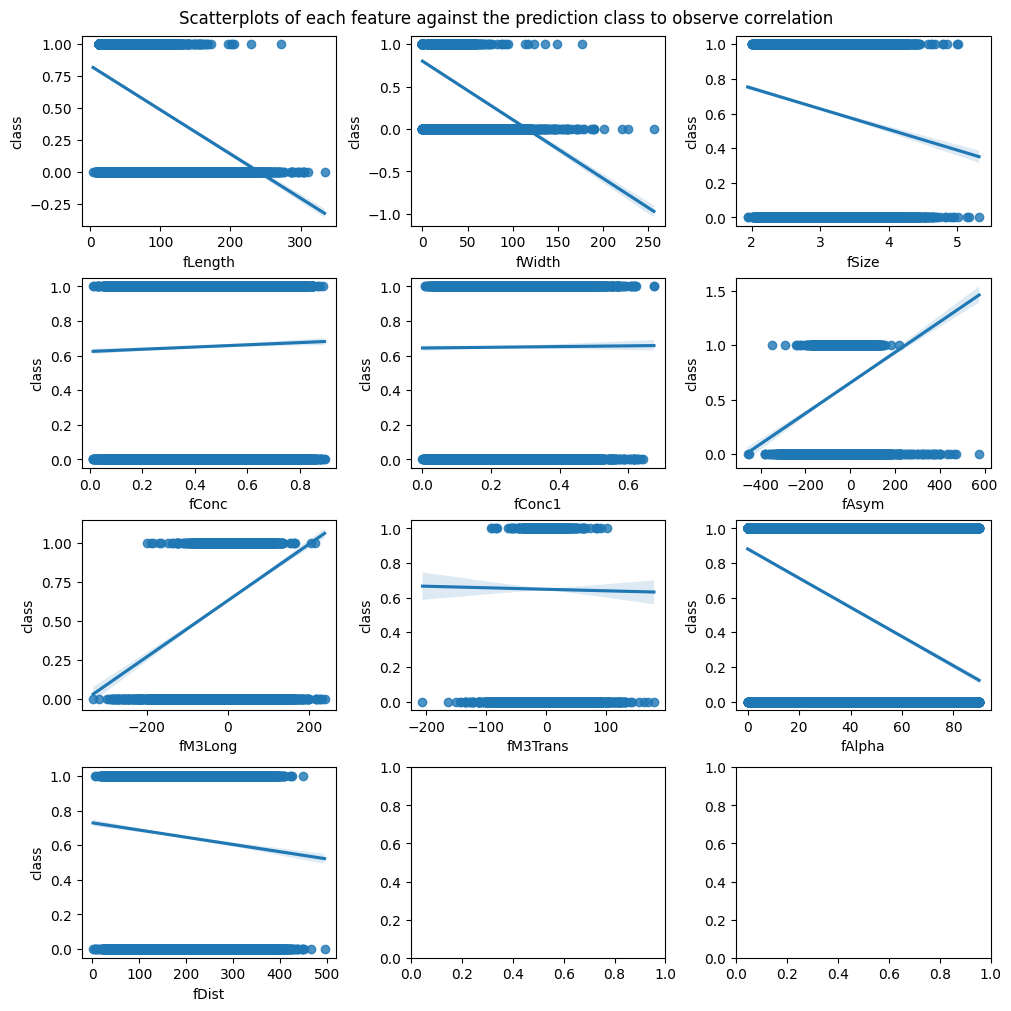

In [6]:
figSize = (10,10)
figWidth = 3
fig, ax = plt.subplots(len(featureNames)//figWidth+1,figWidth, figsize=figSize, layout='constrained')
for k in range(len(featureNames)):
    i = k // figWidth
    j = k - i * figWidth
    feature = featureNames[k]
    sns.regplot(data=data, x=feature, y="class", ax=ax[i,j])
    # ax[i,j].legend()
    # ax[i,j].set_title(f"Area ID = {areas[k]}, R^2 = {scores[k]}")
plt.suptitle("Scatterplots of each feature against the prediction class to observe correlation")
plt.show()

We can eliminate features with low correlation or high p-value, **however** this does not drastically improve the performance of the model, so we will continue to include all features. 

In [7]:
# featureNames = ['fLength', 'fWidth', 'fSize', 'fAsym', 'fM3Long', 'fAlpha', 'fDist']
# num_features = len(featureNames)

## Split Data into Training and Testing

In [8]:
# Get X and y into tensorflow friendly format
X = data[featureNames].values
y = data[classCols].values
# Split
trainX, testX, trainY, testY = train_test_split(X,y)

Standardize:

In [9]:
scaler = StandardScaler()

# Fit only to the training data - computes the mean and standard deviations
scaler.fit(trainX)

# Now apply the transformations to the data:
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)

## Define Neural Network Models

In [10]:
# Model A: Relatively small, 3 hidden layers
modelA = Sequential()
# Input Layer
modelA.add(Dense(num_features, input_dim=num_features))
# Hidden Layers
modelA.add(Dense(num_features*3))
modelA.add(Dense(num_features*6))
modelA.add(Dense(num_features*3))
modelA.add(Dense(num_features))
modelA.add(Dense(num_features//2))
# Output Layer
modelA.add(Dense(num_outputs, activation='sigmoid'))

# Model B: Add more hidden layers, more nodes per layer
modelB = Sequential()
# Input Layer
modelB.add(Dense(num_features, input_dim=num_features))
# Hidden Layers
modelB.add(Dense(num_features*5))
modelB.add(Dense(num_features*10))
modelB.add(Dense(num_features*30))
modelB.add(Dense(num_features*10))
modelB.add(Dense(num_features*5))
modelB.add(Dense(num_features))
# Output Layer
modelB.add(Dense(num_outputs, activation='sigmoid'))

# Model C: Many hidden layers, 2*num_features per node
modelC = Sequential()
# Input Layer
modelC.add(Dense(num_features, input_dim=num_features))
# Hidden Layers
for _ in range(100):
    num_nodes = 2*num_features
    modelC.add(Dense(num_nodes))
    
modelC.add(Dense(num_features))
# Output Layer
modelC.add(Dense(num_outputs, activation='sigmoid'))

# Compile Models
# BinaryCrossEntropy is good for binary classification
modelA.compile(
    loss=BinaryCrossentropy(),
    optimizer='adam',
    metrics=[Precision(), Recall(), F1Score()])

modelB.compile(
    loss=BinaryCrossentropy(),
    optimizer='adam',
    metrics=[Precision(), Recall(), F1Score()])

modelC.compile(
    loss=BinaryCrossentropy(),
    optimizer='adam',
    metrics=[Precision(), Recall(), F1Score()])


## Train Models

In [11]:
# epochs = 100
epochs = 10

modelA.fit(
    trainX, 
    trainY,
    epochs=epochs,
    verbose=1, 
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

modelB.fit(
    trainX, 
    trainY,
    epochs=epochs,
    verbose=1, 
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

modelC.fit(
    trainX, 
    trainY,
    epochs=epochs,
    verbose=1, 
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/10
357/357 [==============================] - 2s 2ms/step - loss: 0.4884 - precision: 0.7883 - recall: 0.8910 - f1_score: 0.7864 - val_loss: 0.4589 - val_precision: 0.8122 - val_recall: 0.8914 - val_f1_score: 0.7939
Epoch 2/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4661 - precision: 0.8007 - recall: 0.8945 - f1_score: 0.7864 - val_loss: 0.4582 - val_precision: 0.8118 - val_recall: 0.8775 - val_f1_score: 0.7939
Epoch 3/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4649 - precision: 0.8014 - recall: 0.8984 - f1_score: 0.7864 - val_loss: 0.4572 - val_precision: 0.7982 - val_recall: 0.8994 - val_f1_score: 0.7939
Epoch 4/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4636 - precision: 0.8010 - recall: 0.8953 - f1_score: 0.7864 - val_loss: 0.4555 - val_precision: 0.8082 - val_recall: 0.8930 - val_f1_score: 0.7939
Epoch 5/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4626 - precision: 0.8032 - r

In [12]:
display(modelA.summary())
display(modelB.summary())
display(modelC.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 30)                330       
                                                                 
 dense_2 (Dense)             (None, 60)                1860      
                                                                 
 dense_3 (Dense)             (None, 30)                1830      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 5)                 55        
                                                                 
 dense_6 (Dense)             (None, 1)                 6

None

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 50)                550       
                                                                 
 dense_9 (Dense)             (None, 100)               5100      
                                                                 
 dense_10 (Dense)            (None, 300)               30300     
                                                                 
 dense_11 (Dense)            (None, 100)               30100     
                                                                 
 dense_12 (Dense)            (None, 50)                5050      
                                                                 
 dense_13 (Dense)            (None, 10)               

None

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 10)                110       
                                                                 
 dense_16 (Dense)            (None, 20)                220       
                                                                 
 dense_17 (Dense)            (None, 20)                420       
                                                                 
 dense_18 (Dense)            (None, 20)                420       
                                                                 
 dense_19 (Dense)            (None, 20)                420       
                                                                 
 dense_20 (Dense)            (None, 20)                420       
                                                                 
 dense_21 (Dense)            (None, 20)               

None

## Evaluate Models

In [13]:
resultsA = modelA.evaluate(testX,testY,batch_size=128)
resultsB = modelB.evaluate(testX,testY,batch_size=128)
resultsC = modelC.evaluate(testX,testY,batch_size=128)

predA = modelA.predict(testX)
predB = modelB.predict(testX)
predC = modelC.predict(testX)

149/149 [==============================] - 1s 2ms/step


If output of neural net is >= 0.5, round to 1, else round to 0

In [14]:
for i in range(len(predA)):
    predA[i] = 1 if predA[i] >= 0.5 else 0
    predB[i] = 1 if predB[i] >= 0.5 else 0
    predC[i] = 1 if predC[i] >= 0.5 else 0


## Precision, Recall, F-Score, Support

In [15]:
metricsA = precision_recall_fscore_support(testY,predA)
metricsB = precision_recall_fscore_support(testY,predB)
metricsC = precision_recall_fscore_support(testY,predC)

display(metricsA)
display(metricsB)
display(metricsC)

(array([0.77830189, 0.79730118]),
 array([0.58372642, 0.90781301]),
 array([0.6671159 , 0.84897585]),
 array([1696, 3059], dtype=int64))

(array([0.75744372, 0.80669035]),
 array([0.61497642, 0.89081399]),
 array([0.67881549, 0.8466677 ]),
 array([1696, 3059], dtype=int64))

(array([0.80886427, 0.77668845]),
 array([0.51650943, 0.93233083]),
 array([0.63044261, 0.84742237]),
 array([1696, 3059], dtype=int64))

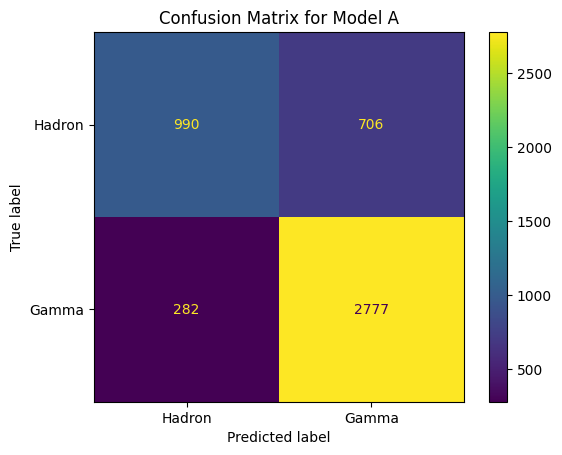

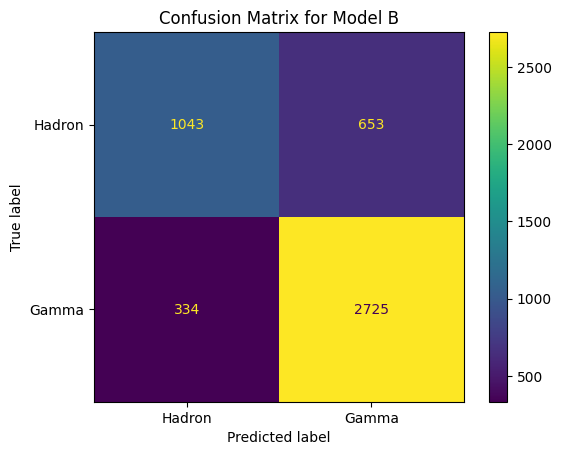

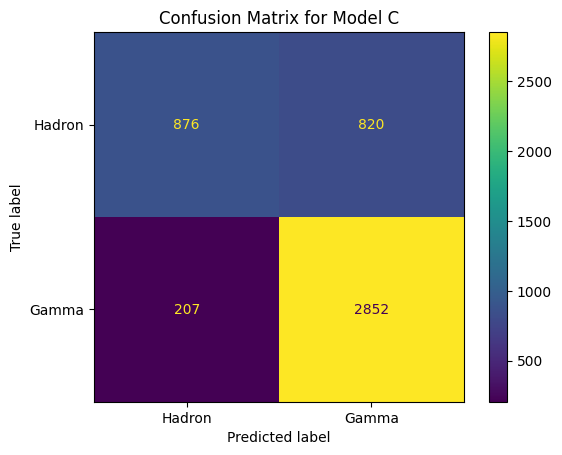

In [16]:
disp = ConfusionMatrixDisplay.from_predictions(testY,predA, display_labels=['Hadron','Gamma'])
disp.ax_.set_title("Confusion Matrix for Model A")
plt.show()
disp = ConfusionMatrixDisplay.from_predictions(testY,predB, display_labels=['Hadron','Gamma'])
disp.ax_.set_title("Confusion Matrix for Model B")
plt.show()
disp = ConfusionMatrixDisplay.from_predictions(testY,predC, display_labels=['Hadron','Gamma'])
disp.ax_.set_title("Confusion Matrix for Model C")
plt.show()